# Global Air Quality Analysis - IDS Semester Project
# Reg# 2023-CS-646

In [4]:
# Import Libraries and Create Output Folders
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats
from scipy.stats import zscore
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report,
                             mean_absolute_error, mean_squared_error, r2_score)
import os
import warnings
warnings.filterwarnings('ignore')

# Create folders for saving graphs
folders = ['graphs/1_preprocessing', 'graphs/2_eda_univariate', 'graphs/3_eda_bivariate', 
           'graphs/4_correlation', 'graphs/5_comparative', 'graphs/6_timeseries', 'graphs/7_models']
for folder in folders:
    os.makedirs(folder, exist_ok=True)

plt.style.use('seaborn-v0_8-whitegrid')
print("✅ Libraries imported and folders created!")

✅ Libraries imported and folders created!


In [5]:
# Load Dataset
df = pd.read_csv('global_air_quality_dataset.csv')
df_original = df.copy()

print(f"Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst 5 rows:")
df.head()

Shape: (10000, 12)

Columns: ['City', 'Country', 'Date', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'Temperature', 'Humidity', 'Wind Speed']

First 5 rows:


,City,Country,Date,PM2.5,PM10,NO2,SO2,CO,O3,Temperature,Humidity,Wind Speed
0,Bangkok,Thailand,2023-03-19,86.57,25.19,99.88,30.63,4.46,36.29,17.67,59.35,13.76
1,Istanbul,Turkey,2023-02-16,50.63,97.39,48.14,8.71,3.40,144.16,3.46,67.51,6.36
2,Rio de Janeiro,Brazil,2023-11-13,130.21,57.22,98.51,9.92,0.12,179.31,25.29,29.30,12.87
3,Mumbai,India,2023-03-16,119.70,130.52,10.96,33.03,7.74,38.65,23.15,99.97,7.71
4,Paris,France,2023-04-04,55.20,36.62,76.85,21.85,2.00,67.09,16.02,90.28,14.16


In [6]:
# Dataset Info and Statistics
print("Data Types:")
print(df.dtypes)
print("\nStatistical Summary:")
df.describe()

Data Types:
City            object
Country         object
Date            object
PM2.5          float64
PM10           float64
NO2            float64
SO2            float64
CO             float64
O3             float64
Temperature    float64
Humidity       float64
Wind Speed     float64
dtype: object

Statistical Summary:


,PM2.5,PM10,NO2,SO2,CO,O3,Temperature,Humidity,Wind Speed
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,77.448439,104.438161,52.198649,25.344490,5.047984,106.031643,14.89715,55.078579,10.231636
std,41.927871,55.062396,27.320490,14.091194,2.852625,55.081345,14.44380,25.982232,5.632628
min,5.020000,10.000000,5.010000,1.000000,0.100000,10.040000,-10.00000,10.010000,0.500000
25%,41.185000,57.137500,28.347500,13.190000,2.560000,58.380000,2.25750,32.527500,5.290000
50%,77.725000,103.690000,52.100000,25.350000,5.090000,106.055000,14.75500,55.080000,10.260000
75%,113.392500,152.265000,75.705000,37.500000,7.480000,153.982500,27.38250,77.442500,15.070000
max,149.980000,200.000000,100.000000,49.990000,10.000000,200.000000,40.00000,99.990000,20.000000


## 1. Data Preprocessing & Cleaning

Missing Values:
City           0
Country        0
Date           0
PM2.5          0
PM10           0
NO2            0
SO2            0
CO             0
O3             0
Temperature    0
Humidity       0
Wind Speed     0
dtype: int64


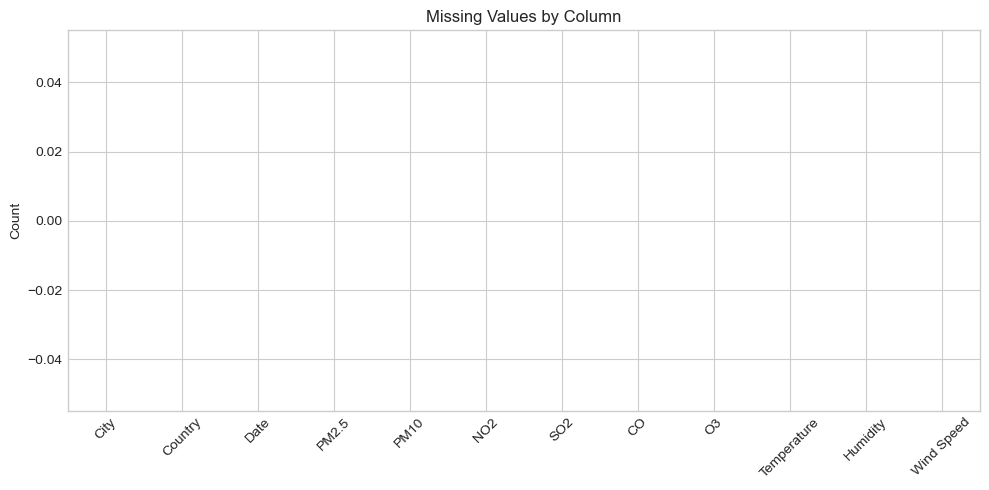


✅ Missing values after imputation: 0


In [7]:
# 1.1 Check and Handle Missing Values
print("Missing Values:")
print(df.isnull().sum())

# Visualize missing values
fig, ax = plt.subplots(figsize=(10, 5))
df.isnull().sum().plot(kind='bar', color=['red' if x > 0 else 'green' for x in df.isnull().sum()])
plt.title('Missing Values by Column')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('graphs/1_preprocessing/missing_values.png', dpi=150)
plt.show()

# Impute missing values
numerical_cols = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'Temperature', 'Humidity', 'Wind Speed']
for col in numerical_cols:
    df[col].fillna(df[col].median(), inplace=True)

print("\n✅ Missing values after imputation:", df.isnull().sum().sum())

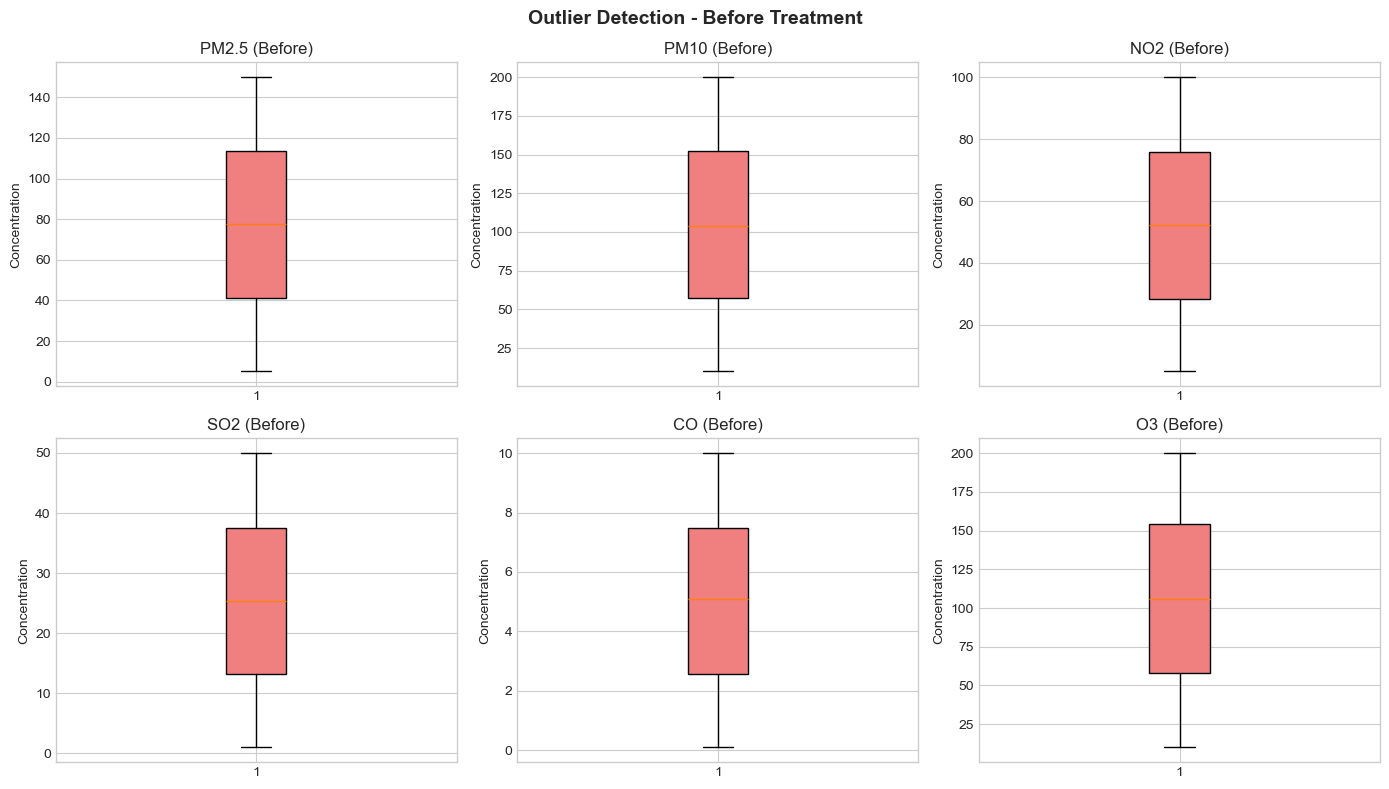

In [8]:
# 1.2 Outlier Detection - Box Plots Before Treatment
pollutant_cols = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()
for i, col in enumerate(pollutant_cols):
    axes[i].boxplot(df[col], patch_artist=True, boxprops=dict(facecolor='lightcoral'))
    axes[i].set_title(f'{col} (Before)')
    axes[i].set_ylabel('Concentration')
plt.suptitle('Outlier Detection - Before Treatment', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('graphs/1_preprocessing/outliers_before.png', dpi=150)
plt.show()

In [9]:
# 1.3 Outlier Detection using IQR and Z-Score Methods
print("Outlier Detection Summary:")
print("-" * 60)

for col in numerical_cols:
    # IQR Method
    Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
    IQR = Q3 - Q1
    iqr_outliers = ((df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)).sum()
    
    # Z-Score Method
    z_outliers = (np.abs(zscore(df[col])) > 3).sum()
    
    print(f"{col}: IQR Outliers={iqr_outliers}, Z-Score Outliers={z_outliers}")

Outlier Detection Summary:
------------------------------------------------------------
PM2.5: IQR Outliers=0, Z-Score Outliers=0
PM10: IQR Outliers=0, Z-Score Outliers=0
NO2: IQR Outliers=0, Z-Score Outliers=0
SO2: IQR Outliers=0, Z-Score Outliers=0
CO: IQR Outliers=0, Z-Score Outliers=0
O3: IQR Outliers=0, Z-Score Outliers=0
Temperature: IQR Outliers=0, Z-Score Outliers=0
Humidity: IQR Outliers=0, Z-Score Outliers=0
Wind Speed: IQR Outliers=0, Z-Score Outliers=0


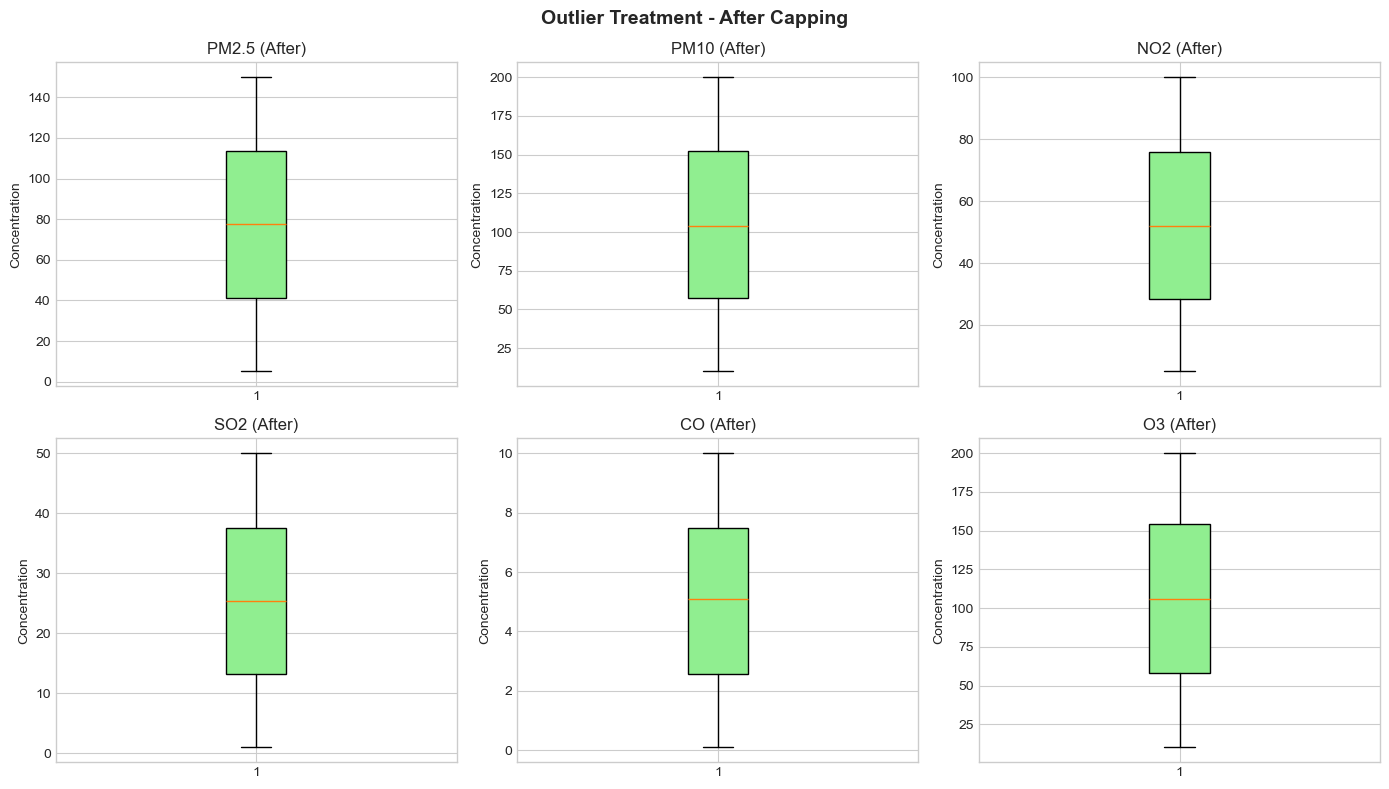

✅ Outliers handled using IQR capping


In [10]:
# 1.4 Handle Outliers using IQR Capping
for col in numerical_cols:
    Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    df[col] = df[col].clip(lower, upper)

# Box Plots After Treatment
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()
for i, col in enumerate(pollutant_cols):
    axes[i].boxplot(df[col], patch_artist=True, boxprops=dict(facecolor='lightgreen'))
    axes[i].set_title(f'{col} (After)')
    axes[i].set_ylabel('Concentration')
plt.suptitle('Outlier Treatment - After Capping', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('graphs/1_preprocessing/outliers_after.png', dpi=150)
plt.show()
print("✅ Outliers handled using IQR capping")

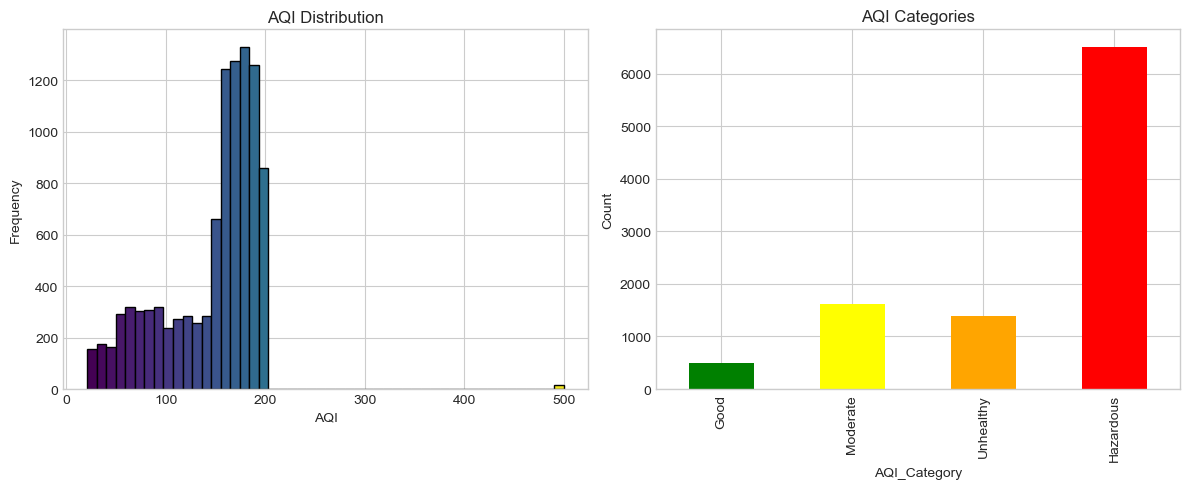

AQI Category Distribution:
AQI_Category
Hazardous    6514
Moderate     1609
Unhealthy    1380
Good          497
Name: count, dtype: int64


In [11]:
# 1.5 Calculate AQI and Create Categories
pm25_bp = [(0, 12, 0, 50), (12.1, 35.4, 51, 100), (35.5, 55.4, 101, 150),
           (55.5, 150.4, 151, 200), (150.5, 250.4, 201, 300), (250.5, 500, 301, 500)]

def calc_aqi(pm25):
    for low, high, aqi_low, aqi_high in pm25_bp:
        if low <= pm25 <= high:
            return ((aqi_high - aqi_low) / (high - low)) * (pm25 - low) + aqi_low
    return 500

df['AQI'] = df['PM2.5'].apply(calc_aqi)

# Categorize AQI
def aqi_category(aqi):
    if aqi <= 50: return 'Good'
    elif aqi <= 100: return 'Moderate'
    elif aqi <= 150: return 'Unhealthy'
    else: return 'Hazardous'

df['AQI_Category'] = df['AQI'].apply(aqi_category)
df['AQI_Encoded'] = df['AQI_Category'].map({'Good': 0, 'Moderate': 1, 'Unhealthy': 2, 'Hazardous': 3})

# Visualize AQI Distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
n, bins, patches = axes[0].hist(df['AQI'], bins=50, edgecolor='black')
cmap = plt.cm.viridis
for i, p in enumerate(patches):
    p.set_facecolor(cmap(i / len(patches)))
axes[0].set_title('AQI Distribution')
axes[0].set_xlabel('AQI')
axes[0].set_ylabel('Frequency')


colors = ['green', 'yellow', 'orange', 'red']
df['AQI_Category'].value_counts().reindex(['Good', 'Moderate', 'Unhealthy', 'Hazardous']).plot(
    kind='bar', ax=axes[1], color=colors)
axes[1].set_title('AQI Categories')
axes[1].set_ylabel('Count')
plt.tight_layout()
plt.savefig('graphs/1_preprocessing/aqi_distribution.png', dpi=150)
plt.show()

print("AQI Category Distribution:")
print(df['AQI_Category'].value_counts())

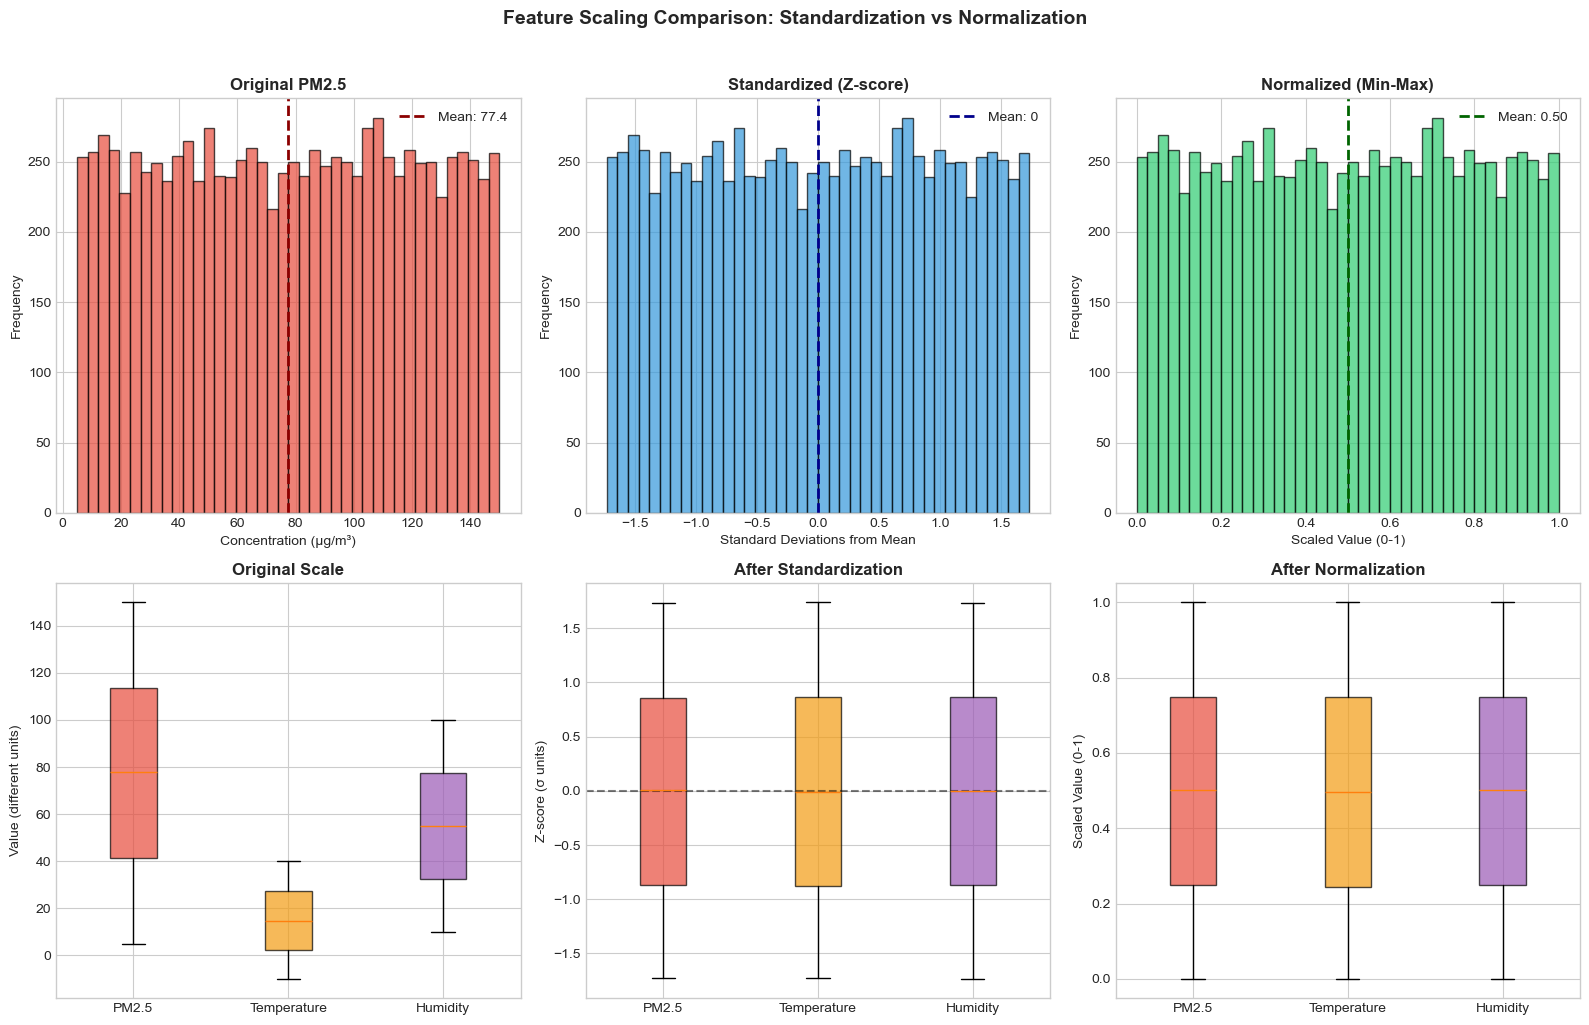

📊 Scaling Methods Summary:
------------------------------------------------------------
Method               Mean            Std             Range
------------------------------------------------------------
Original PM2.5       77.45           41.93           [5.0, 150.0]
Standardized         -0.00           1.00            [-1.73, 1.73]
Normalized           0.50            0.29            [0.00, 1.00]
------------------------------------------------------------
✅ StandardScaler: Mean=0, Std=1 (useful for algorithms sensitive to scale)
✅ MinMaxScaler: Range [0,1] (preserves original distribution shape)


In [12]:
# 1.6 Feature Scaling - Standardization and Normalization
features = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'Temperature', 'Humidity', 'Wind Speed']

# Compare scaling methods
scaler_std = StandardScaler()
scaler_mm = MinMaxScaler()

df_std = df.copy()
df_norm = df.copy()
df_std[features] = scaler_std.fit_transform(df[features])
df_norm[features] = scaler_mm.fit_transform(df[features])

# Enhanced Visualization
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Row 1: PM2.5 Scaling Comparison
axes[0,0].hist(df['PM2.5'], bins=40, color='#e74c3c', alpha=0.7, edgecolor='black')
axes[0,0].axvline(df['PM2.5'].mean(), color='darkred', linestyle='--', linewidth=2, label=f'Mean: {df["PM2.5"].mean():.1f}')
axes[0,0].set_title('Original PM2.5', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Concentration (µg/m³)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()

axes[0,1].hist(df_std['PM2.5'], bins=40, color='#3498db', alpha=0.7, edgecolor='black')
axes[0,1].axvline(0, color='darkblue', linestyle='--', linewidth=2, label='Mean: 0')
axes[0,1].set_title('Standardized (Z-score)', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('Standard Deviations from Mean')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()

axes[0,2].hist(df_norm['PM2.5'], bins=40, color='#2ecc71', alpha=0.7, edgecolor='black')
axes[0,2].axvline(df_norm['PM2.5'].mean(), color='darkgreen', linestyle='--', linewidth=2, label=f'Mean: {df_norm["PM2.5"].mean():.2f}')
axes[0,2].set_title('Normalized (Min-Max)', fontsize=12, fontweight='bold')
axes[0,2].set_xlabel('Scaled Value (0-1)')
axes[0,2].set_ylabel('Frequency')
axes[0,2].legend()

# Row 2: Before/After comparison for multiple features
sample_features = ['PM2.5', 'Temperature', 'Humidity']
colors = ['#e74c3c', '#f39c12', '#9b59b6']

# Original scale boxplot
bp1 = axes[1,0].boxplot([df[f] for f in sample_features], patch_artist=True, labels=sample_features)
for patch, color in zip(bp1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1,0].set_title('Original Scale', fontsize=12, fontweight='bold')
axes[1,0].set_ylabel('Value (different units)')

# Standardized boxplot
bp2 = axes[1,1].boxplot([df_std[f] for f in sample_features], patch_artist=True, labels=sample_features)
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1,1].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[1,1].set_title('After Standardization', fontsize=12, fontweight='bold')
axes[1,1].set_ylabel('Z-score (σ units)')

# Normalized boxplot
bp3 = axes[1,2].boxplot([df_norm[f] for f in sample_features], patch_artist=True, labels=sample_features)
for patch, color in zip(bp3['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1,2].set_title('After Normalization', fontsize=12, fontweight='bold')
axes[1,2].set_ylabel('Scaled Value (0-1)')

plt.suptitle('Feature Scaling Comparison: Standardization vs Normalization', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('graphs/1_preprocessing/scaling_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary statistics
print("📊 Scaling Methods Summary:")
print("-" * 60)
print(f"{'Method':<20} {'Mean':<15} {'Std':<15} {'Range'}")
print("-" * 60)
print(f"{'Original PM2.5':<20} {df['PM2.5'].mean():<15.2f} {df['PM2.5'].std():<15.2f} [{df['PM2.5'].min():.1f}, {df['PM2.5'].max():.1f}]")
print(f"{'Standardized':<20} {df_std['PM2.5'].mean():<15.2f} {df_std['PM2.5'].std():<15.2f} [{df_std['PM2.5'].min():.2f}, {df_std['PM2.5'].max():.2f}]")
print(f"{'Normalized':<20} {df_norm['PM2.5'].mean():<15.2f} {df_norm['PM2.5'].std():<15.2f} [{df_norm['PM2.5'].min():.2f}, {df_norm['PM2.5'].max():.2f}]")
print("-" * 60)
print("✅ StandardScaler: Mean=0, Std=1 (useful for algorithms sensitive to scale)")
print("✅ MinMaxScaler: Range [0,1] (preserves original distribution shape)")

In [13]:
# 1.7 Train-Test Split (80-20)
X = df[features]
y = df['AQI_Encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.0f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.0f}%)")
print(f"\nClass distribution in training set:")
print(pd.Series(y_train).value_counts().sort_index())

Training set: 8000 samples (80%)
Test set: 2000 samples (20%)

Class distribution in training set:
AQI_Encoded
0     398
1    1287
2    1104
3    5211
Name: count, dtype: int64


## 2. Exploratory Data Analysis (EDA)

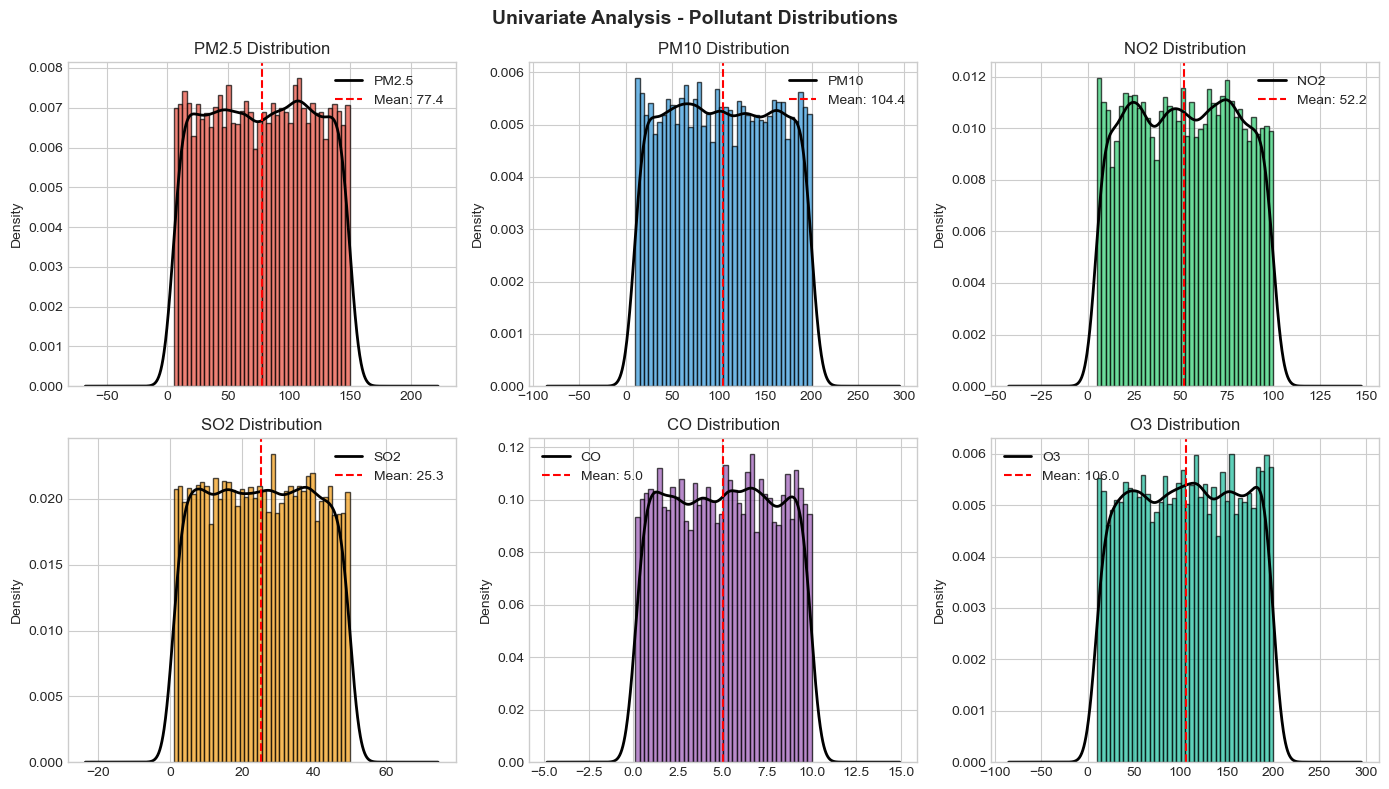

In [14]:
# 2.1 Univariate Analysis - Pollutant Distributions
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']

for i, (col, color) in enumerate(zip(pollutant_cols, colors)):
    axes[i].hist(df[col], bins=40, color=color, alpha=0.7, edgecolor='black', density=True)
    df[col].plot(kind='kde', ax=axes[i], color='black', linewidth=2)
    axes[i].axvline(df[col].mean(), color='red', linestyle='--', label=f'Mean: {df[col].mean():.1f}')
    axes[i].set_title(f'{col} Distribution')
    axes[i].legend()
plt.suptitle('Univariate Analysis - Pollutant Distributions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('graphs/2_eda_univariate/pollutant_distributions.png', dpi=150)
plt.show()

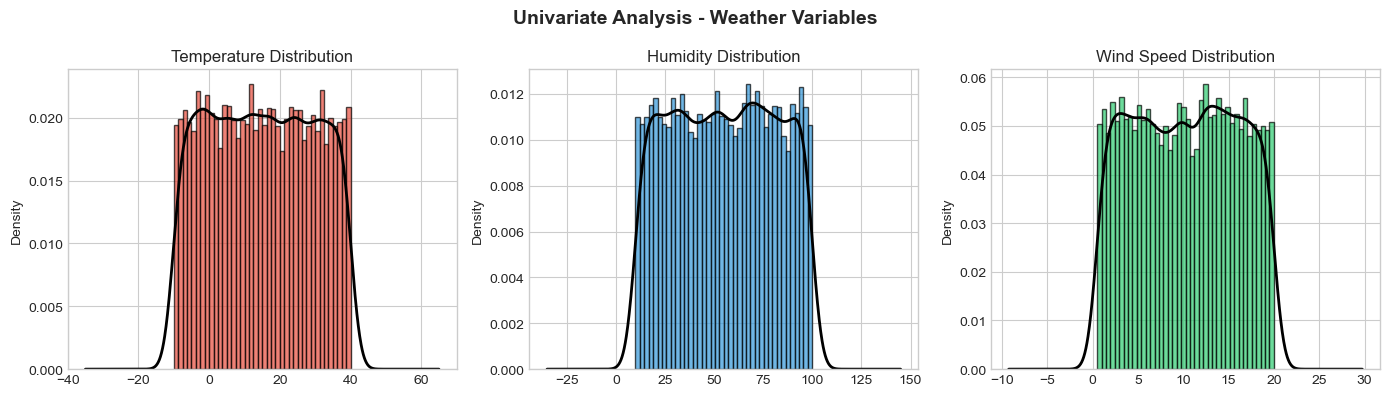

In [15]:
# 2.1b Univariate Analysis - Weather Variables
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
weather_cols = ['Temperature', 'Humidity', 'Wind Speed']
weather_colors = ['#e74c3c', '#3498db', '#2ecc71']

for i, (col, color) in enumerate(zip(weather_cols, weather_colors)):
    axes[i].hist(df[col], bins=40, color=color, alpha=0.7, edgecolor='black', density=True)
    df[col].plot(kind='kde', ax=axes[i], color='black', linewidth=2)
    axes[i].set_title(f'{col} Distribution')
plt.suptitle('Univariate Analysis - Weather Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('graphs/2_eda_univariate/weather_distributions.png', dpi=150)
plt.show()

In [16]:
# 2.1c Skewness and Kurtosis Analysis
print("Skewness and Kurtosis Analysis:")
print("-" * 50)
for col in numerical_cols:
    skew = df[col].skew()
    kurt = df[col].kurtosis()
    print(f"{col}: Skewness={skew:.3f}, Kurtosis={kurt:.3f}")

Skewness and Kurtosis Analysis:
--------------------------------------------------
PM2.5: Skewness=-0.006, Kurtosis=-1.204
PM10: Skewness=0.011, Kurtosis=-1.201
NO2: Skewness=-0.002, Kurtosis=-1.192
SO2: Skewness=0.007, Kurtosis=-1.192
CO: Skewness=-0.002, Kurtosis=-1.199
O3: Skewness=-0.014, Kurtosis=-1.196
Temperature: Skewness=0.013, Kurtosis=-1.201
Humidity: Skewness=-0.006, Kurtosis=-1.201
Wind Speed: Skewness=-0.008, Kurtosis=-1.209


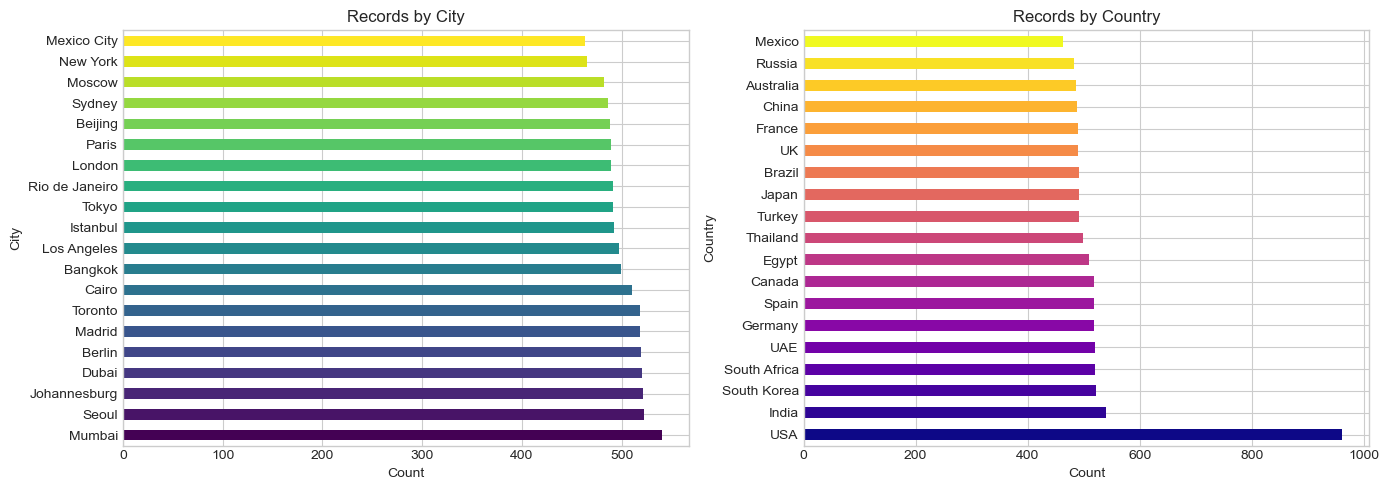

In [17]:
# 2.1d Categorical Variables Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df['City'].value_counts().plot(kind='barh', ax=axes[0], color=plt.cm.viridis(np.linspace(0, 1, df['City'].nunique())))
axes[0].set_title('Records by City')
axes[0].set_xlabel('Count')

df['Country'].value_counts().plot(kind='barh', ax=axes[1], color=plt.cm.plasma(np.linspace(0, 1, df['Country'].nunique())))
axes[1].set_title('Records by Country')
axes[1].set_xlabel('Count')

plt.tight_layout()
plt.savefig('graphs/2_eda_univariate/categorical_distribution.png', dpi=150)
plt.show()

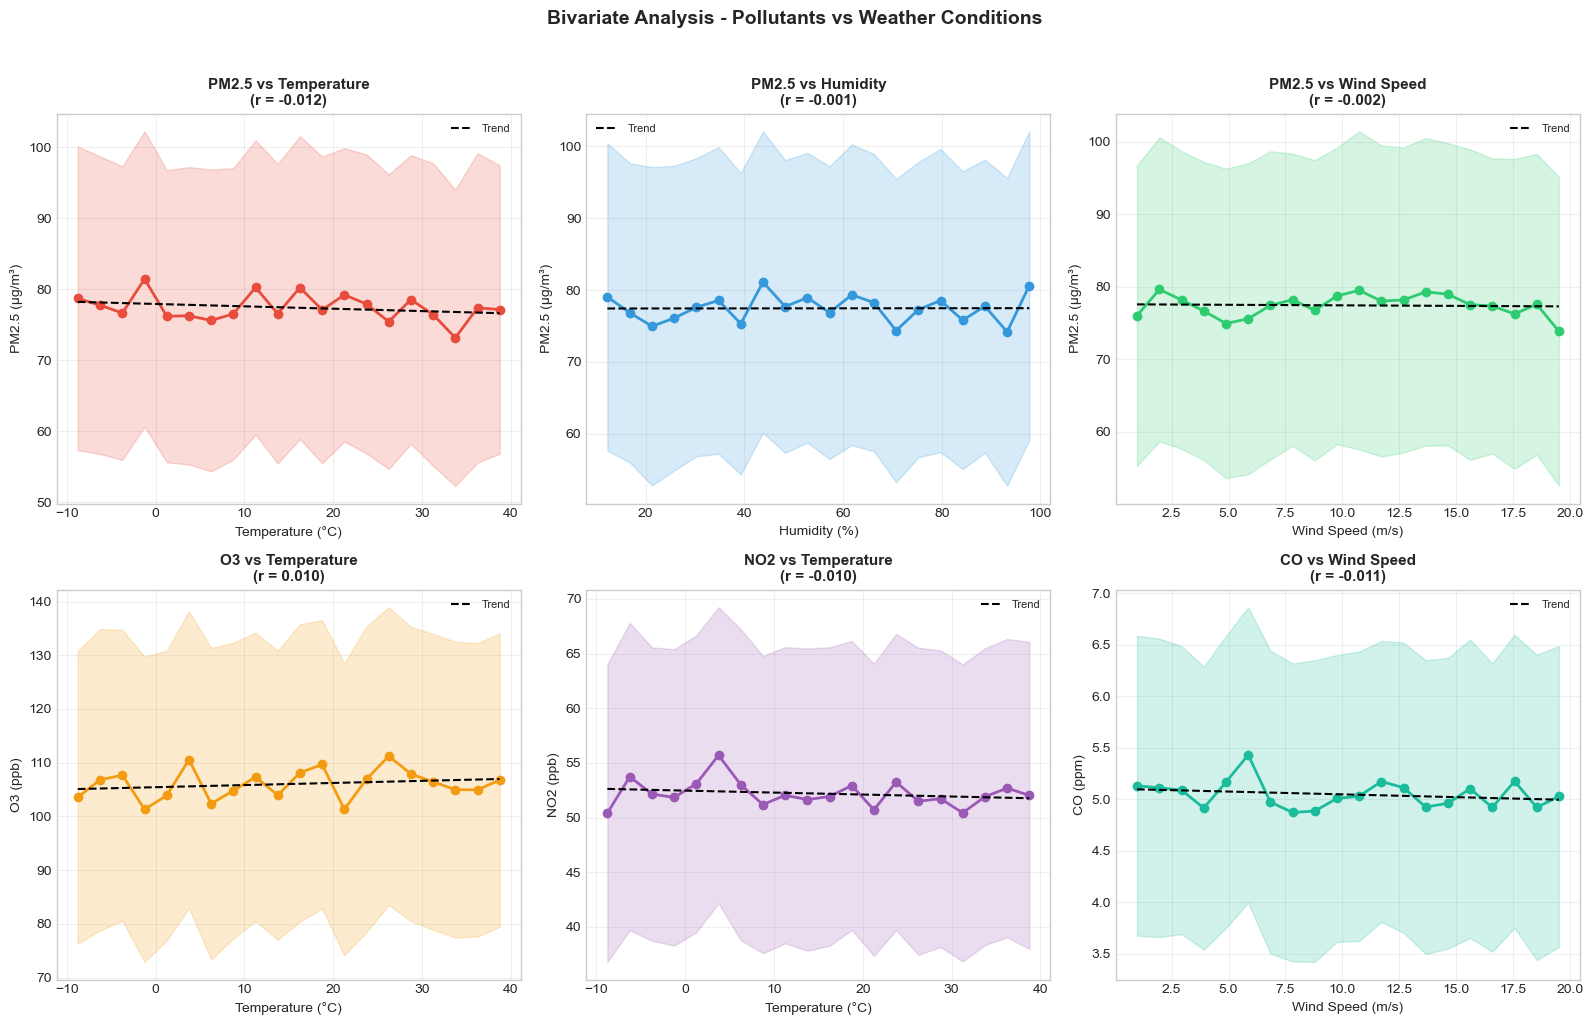

📊 Key Observations:
--------------------------------------------------
  Temperature ↔ PM2.5:  r = -0.012
  Humidity ↔ PM2.5:     r = -0.001
  Wind Speed ↔ PM2.5:   r = -0.002
  Temperature ↔ O3:     r = 0.010
  Temperature ↔ NO2:    r = -0.010
  Wind Speed ↔ CO:      r = -0.011


In [18]:
# 2.2 Bivariate Analysis - Pollutants vs Weather (Line Charts with Trend)
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Helper function to create binned line chart with trend
def plot_bivariate_line(ax, x_col, y_col, color, xlabel, ylabel, title):
    # Create bins for x variable
    df_temp = df[[x_col, y_col]].dropna()
    df_temp['bin'] = pd.cut(df_temp[x_col], bins=20)
    grouped = df_temp.groupby('bin')[y_col].agg(['mean', 'std']).reset_index()
    grouped['bin_mid'] = grouped['bin'].apply(lambda x: x.mid)
    grouped = grouped.dropna()
    
    # Plot line with confidence band
    ax.plot(grouped['bin_mid'], grouped['mean'], marker='o', linewidth=2, color=color, markersize=6)
    ax.fill_between(grouped['bin_mid'], 
                    grouped['mean'] - grouped['std']/2, 
                    grouped['mean'] + grouped['std']/2, 
                    alpha=0.2, color=color)
    
    # Add trend line
    z = np.polyfit(grouped['bin_mid'], grouped['mean'], 1)
    p = np.poly1d(z)
    ax.plot(grouped['bin_mid'], p(grouped['bin_mid']), '--', color='black', linewidth=1.5, label='Trend')
    
    # Calculate correlation
    corr = df[x_col].corr(df[y_col])
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_title(f'{title}\n(r = {corr:.3f})', fontsize=11, fontweight='bold')
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)

# Row 1: PM2.5 relationships
plot_bivariate_line(axes[0,0], 'Temperature', 'PM2.5', '#e74c3c', 
                    'Temperature (°C)', 'PM2.5 (µg/m³)', 'PM2.5 vs Temperature')
plot_bivariate_line(axes[0,1], 'Humidity', 'PM2.5', '#3498db', 
                    'Humidity (%)', 'PM2.5 (µg/m³)', 'PM2.5 vs Humidity')
plot_bivariate_line(axes[0,2], 'Wind Speed', 'PM2.5', '#2ecc71', 
                    'Wind Speed (m/s)', 'PM2.5 (µg/m³)', 'PM2.5 vs Wind Speed')

# Row 2: Other pollutants
plot_bivariate_line(axes[1,0], 'Temperature', 'O3', '#f39c12', 
                    'Temperature (°C)', 'O3 (ppb)', 'O3 vs Temperature')
plot_bivariate_line(axes[1,1], 'Temperature', 'NO2', '#9b59b6', 
                    'Temperature (°C)', 'NO2 (ppb)', 'NO2 vs Temperature')
plot_bivariate_line(axes[1,2], 'Wind Speed', 'CO', '#1abc9c', 
                    'Wind Speed (m/s)', 'CO (ppm)', 'CO vs Wind Speed')

plt.suptitle('Bivariate Analysis - Pollutants vs Weather Conditions', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('graphs/3_eda_bivariate/pollutants_vs_weather.png', dpi=150, bbox_inches='tight')
plt.show()

print("📊 Key Observations:")
print("-" * 50)
print(f"  Temperature ↔ PM2.5:  r = {df['Temperature'].corr(df['PM2.5']):.3f}")
print(f"  Humidity ↔ PM2.5:     r = {df['Humidity'].corr(df['PM2.5']):.3f}")
print(f"  Wind Speed ↔ PM2.5:   r = {df['Wind Speed'].corr(df['PM2.5']):.3f}")
print(f"  Temperature ↔ O3:     r = {df['Temperature'].corr(df['O3']):.3f}")
print(f"  Temperature ↔ NO2:    r = {df['Temperature'].corr(df['NO2']):.3f}")
print(f"  Wind Speed ↔ CO:      r = {df['Wind Speed'].corr(df['CO']):.3f}")

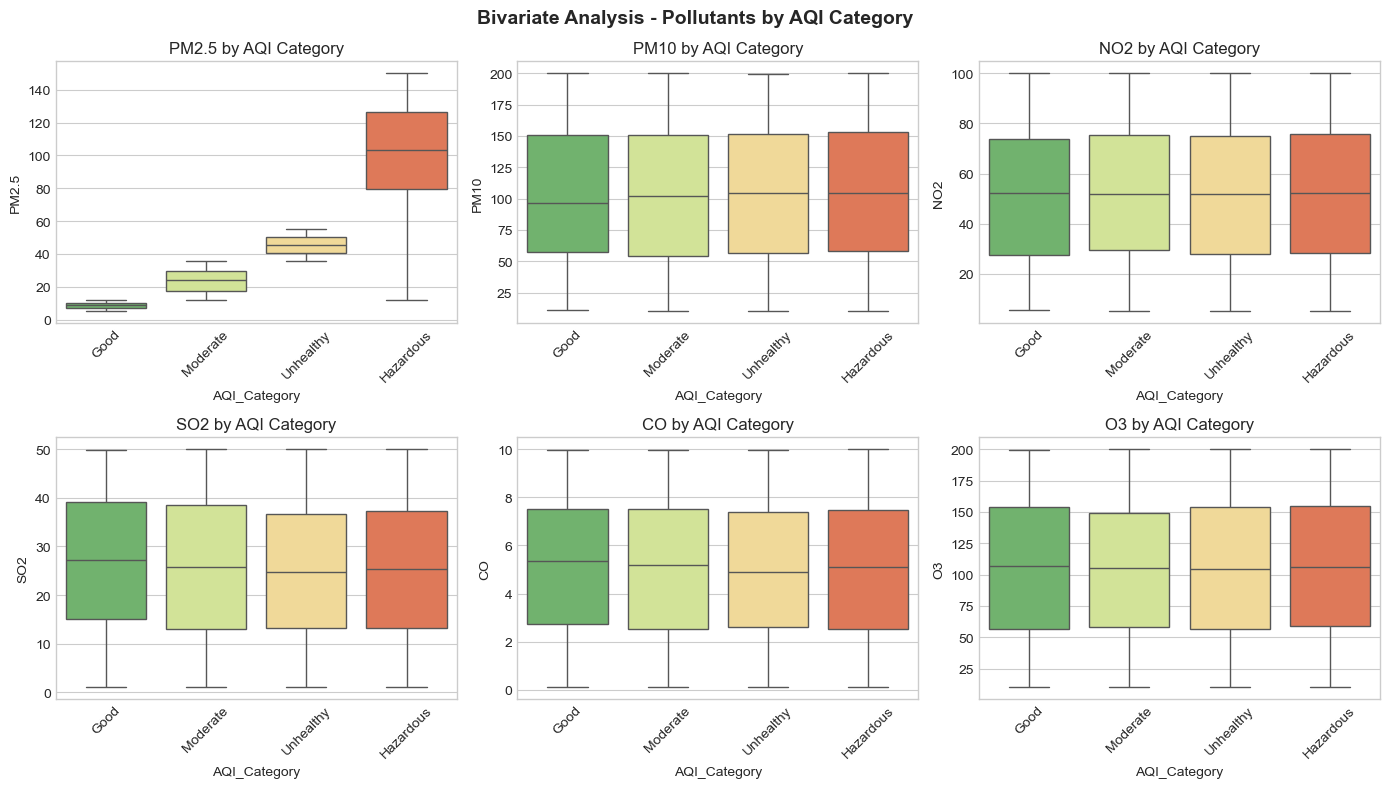

In [19]:
# 2.2b Bivariate - Pollutants by AQI Category
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()
order = ['Good', 'Moderate', 'Unhealthy', 'Hazardous']

for i, col in enumerate(pollutant_cols):
    sns.boxplot(data=df, x='AQI_Category', y=col, ax=axes[i], order=order, palette='RdYlGn_r')
    axes[i].set_title(f'{col} by AQI Category')
    axes[i].tick_params(axis='x', rotation=45)
plt.suptitle('Bivariate Analysis - Pollutants by AQI Category', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('graphs/3_eda_bivariate/pollutants_by_aqi.png', dpi=150)
plt.show()

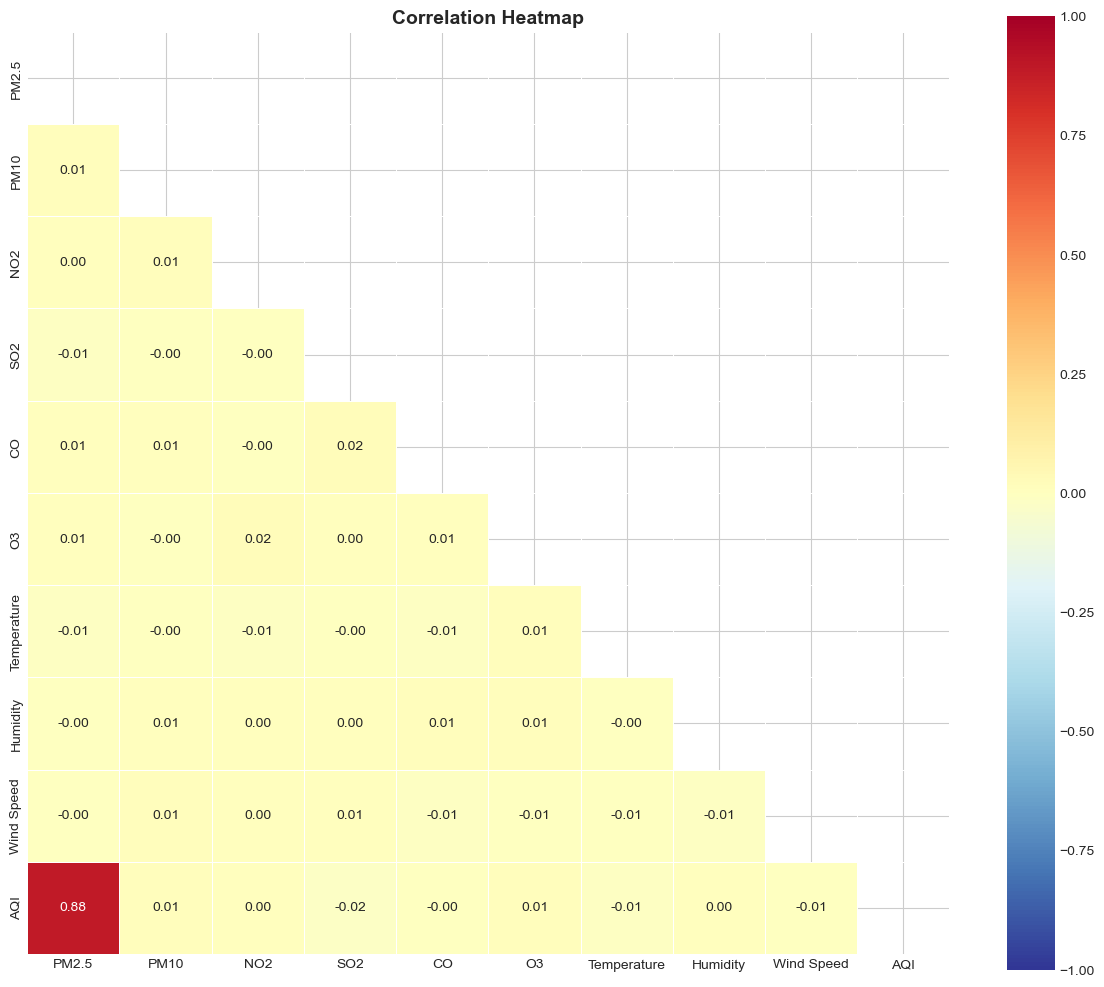

Strong Correlations (|r| > 0.5):
  PM2.5 ↔ AQI: 0.883


In [20]:
# 2.3 Correlation Analysis
corr_cols = numerical_cols + ['AQI']
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdYlBu_r', 
            center=0, square=True, linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('graphs/4_correlation/correlation_heatmap.png', dpi=150)
plt.show()

# Strong correlations
print("Strong Correlations (|r| > 0.5):")
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.5:
            print(f"  {corr_matrix.columns[i]} ↔ {corr_matrix.columns[j]}: {corr_matrix.iloc[i, j]:.3f}")

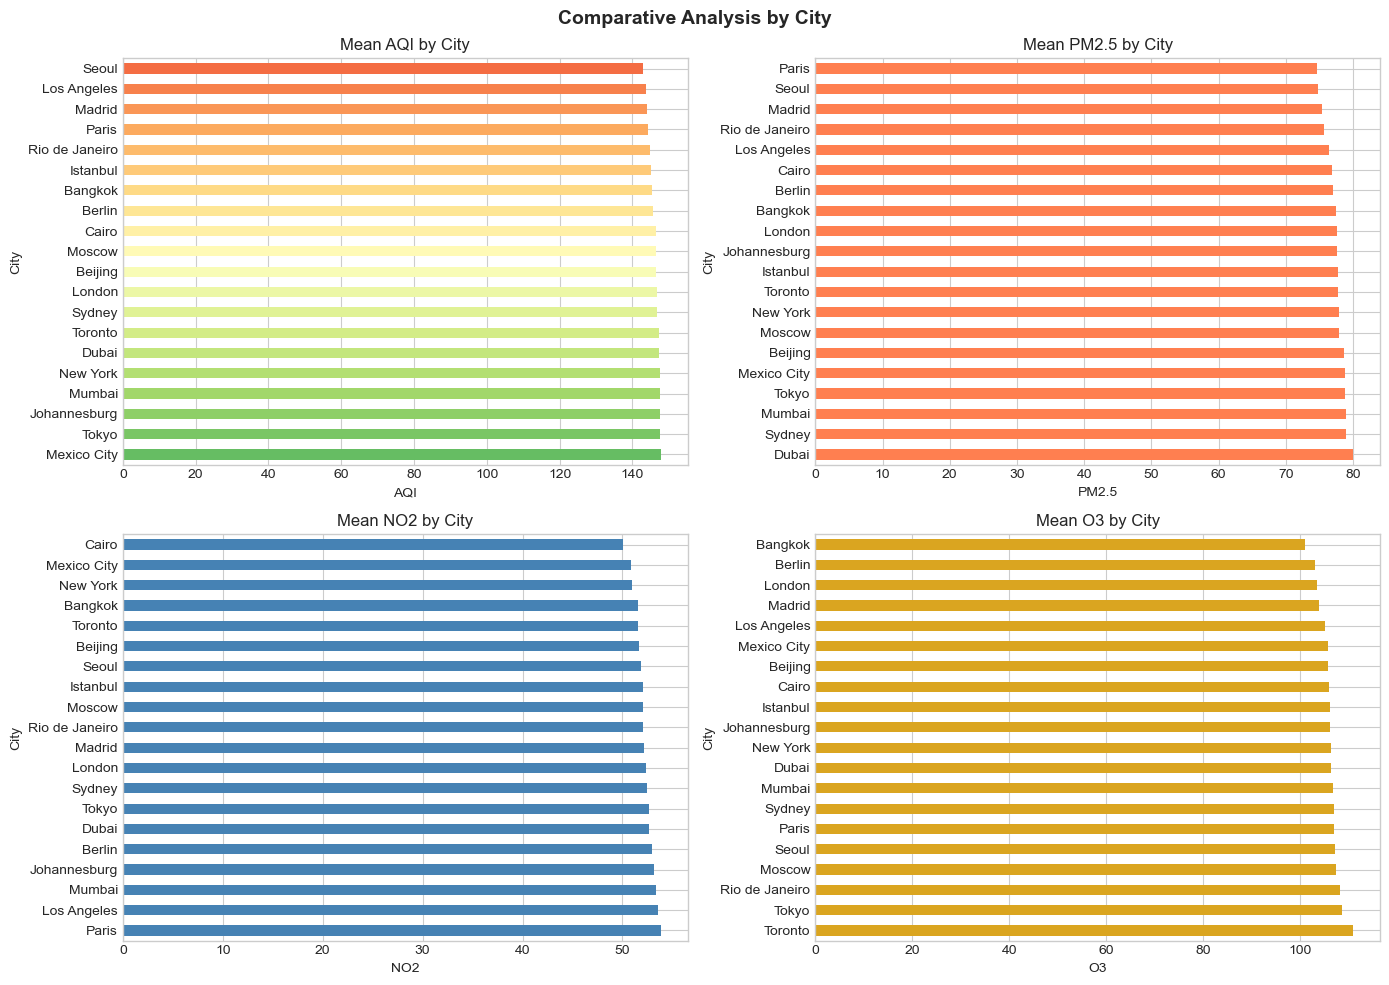

In [21]:
# 2.4 Comparative Analysis - By City
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

city_aqi = df.groupby('City')['AQI'].mean().sort_values(ascending=False)
city_aqi.plot(kind='barh', ax=axes[0,0], color=plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(city_aqi))))
axes[0,0].set_title('Mean AQI by City'); axes[0,0].set_xlabel('AQI')

city_pm25 = df.groupby('City')['PM2.5'].mean().sort_values(ascending=False)
city_pm25.plot(kind='barh', ax=axes[0,1], color='coral')
axes[0,1].set_title('Mean PM2.5 by City'); axes[0,1].set_xlabel('PM2.5')

city_no2 = df.groupby('City')['NO2'].mean().sort_values(ascending=False)
city_no2.plot(kind='barh', ax=axes[1,0], color='steelblue')
axes[1,0].set_title('Mean NO2 by City'); axes[1,0].set_xlabel('NO2')

city_o3 = df.groupby('City')['O3'].mean().sort_values(ascending=False)
city_o3.plot(kind='barh', ax=axes[1,1], color='goldenrod')
axes[1,1].set_title('Mean O3 by City'); axes[1,1].set_xlabel('O3')

plt.suptitle('Comparative Analysis by City', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('graphs/5_comparative/city_comparison.png', dpi=150)
plt.show()

In [22]:
# 2.4b Comparative Analysis - By Country

print("Mean Pollutants by Country:")
print(df.groupby('Country')[pollutant_cols + ['AQI']].mean().round(2))

Mean Pollutants by Country:
              PM2.5    PM10    NO2    SO2    CO      O3     AQI
Country                                                        
Australia     78.93  103.37  52.47  25.68  5.02  106.82  146.86
Brazil        75.67  105.44  52.10  24.58  4.91  108.07  144.86
Canada        77.83  103.87  51.55  24.80  4.95  110.85  147.27
China         78.63  103.19  51.62  24.90  5.09  105.74  146.48
Egypt         76.89  102.99  50.06  24.99  5.13  105.93  146.33
France        74.69  104.64  53.82  24.57  4.94  106.91  144.13
Germany       76.97  104.37  52.96  24.51  4.97  102.93  145.65
India         78.90  105.84  53.34  25.03  5.08  106.64  147.51
Japan         78.87  105.04  52.67  27.98  5.10  108.48  147.64
Mexico        78.86  104.53  50.86  26.02  5.14  105.69  147.73
Russia        77.88  105.94  52.03  26.11  5.12  107.29  146.34
South Africa  77.67  105.14  53.15  24.67  5.09  106.18  147.62
South Korea   74.80  105.00  51.88  25.01  4.89  107.02  142.83
Spain       

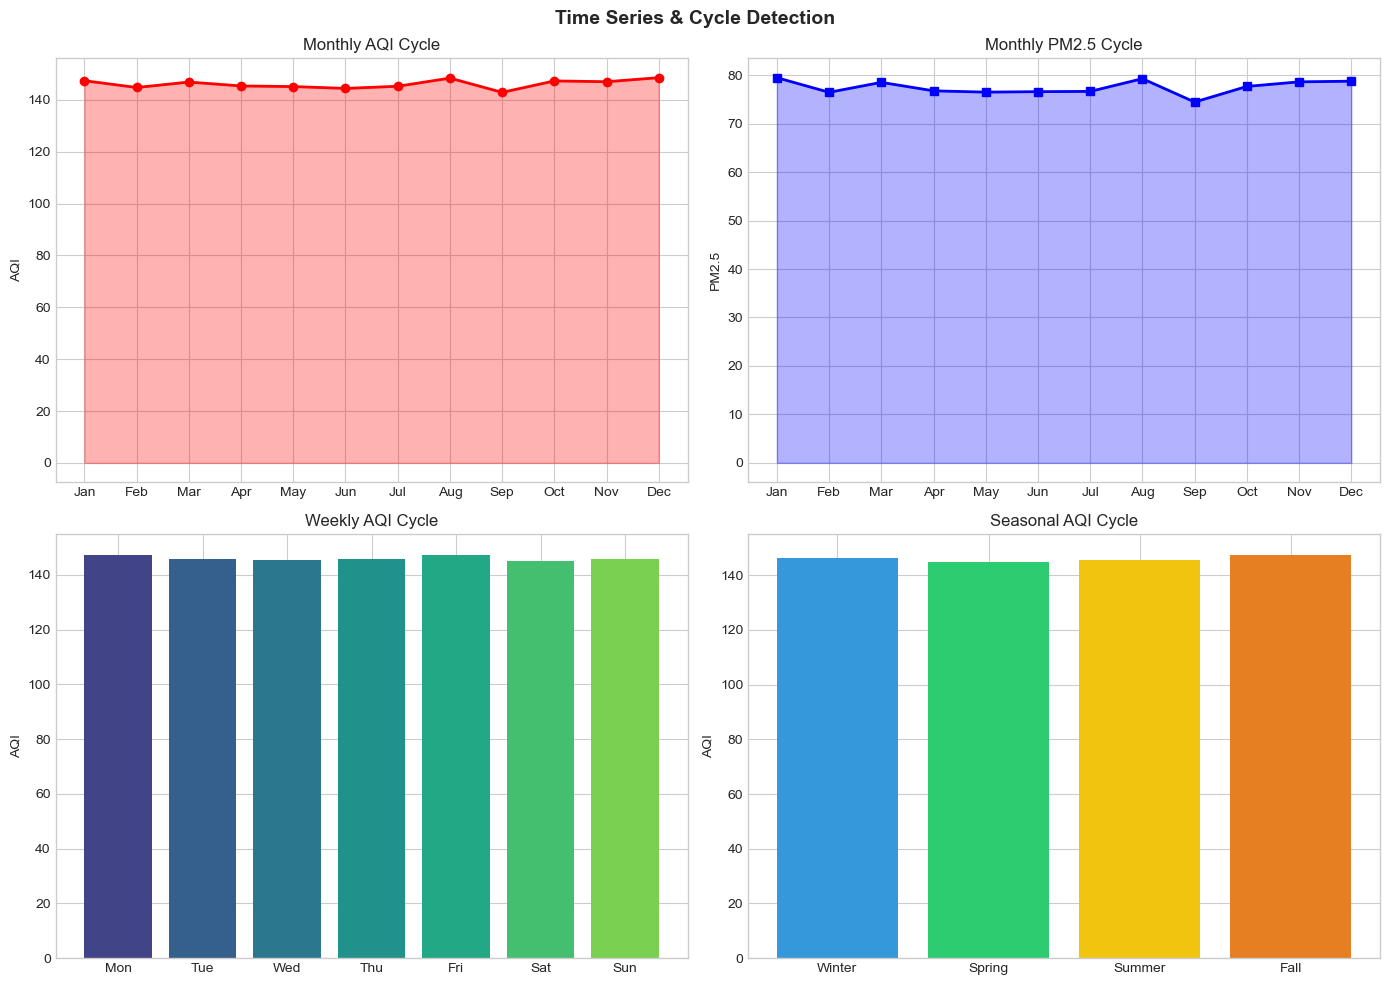

In [23]:
# 2.5 Time Series & Cycle Detection
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Quarter'] = df['Date'].dt.quarter

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Monthly Cycle
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

monthly_aqi = df.groupby('Month')['AQI'].mean()
axes[0,0].plot(monthly_aqi.index, monthly_aqi.values, marker='o', linewidth=2, color='red')
axes[0,0].fill_between(monthly_aqi.index, monthly_aqi.values, alpha=0.3, color='red')
axes[0,0].set_xticks(range(1, 13)); axes[0,0].set_xticklabels(month_names)
axes[0,0].set_title('Monthly AQI Cycle'); axes[0,0].set_ylabel('AQI')

monthly_pm25 = df.groupby('Month')['PM2.5'].mean()
axes[0,1].plot(monthly_pm25.index, monthly_pm25.values, marker='s', linewidth=2, color='blue')
axes[0,1].fill_between(monthly_pm25.index, monthly_pm25.values, alpha=0.3, color='blue')
axes[0,1].set_xticks(range(1, 13)); axes[0,1].set_xticklabels(month_names)
axes[0,1].set_title('Monthly PM2.5 Cycle'); axes[0,1].set_ylabel('PM2.5')

# Weekly Cycle
weekly_aqi = df.groupby('DayOfWeek')['AQI'].mean()
axes[1,0].bar(weekly_aqi.index, weekly_aqi.values, color=plt.cm.viridis(np.linspace(0.2, 0.8, 7)))
axes[1,0].set_xticks(range(7)); axes[1,0].set_xticklabels(day_names)
axes[1,0].set_title('Weekly AQI Cycle'); axes[1,0].set_ylabel('AQI')

# Seasonal Cycle
season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
df['Season'] = df['Quarter'].map(season_map)
seasonal_aqi = df.groupby('Season')['AQI'].mean().reindex(['Winter', 'Spring', 'Summer', 'Fall'])
axes[1,1].bar(seasonal_aqi.index, seasonal_aqi.values, color=['#3498db', '#2ecc71', '#f1c40f', '#e67e22'])
axes[1,1].set_title('Seasonal AQI Cycle'); axes[1,1].set_ylabel('AQI')

plt.suptitle('Time Series & Cycle Detection', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('graphs/6_timeseries/cycles.png', dpi=150)
plt.show()

## 3. Model Building & Prediction

In [24]:
# Model Evaluation Function
label_map = {0: 'Good', 1: 'Moderate', 2: 'Unhealthy', 3: 'Hazardous'}
results = []

def train_evaluate_model(name, model):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    cv = cross_val_score(model, X_train_scaled, y_train, cv=5).mean()
    
    results.append({'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1, 'CV Score': cv})
    
    print(f"\n{'='*50}")
    print(f"MODEL: {name}")
    print(f"{'='*50}")
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    print(f"\nConfusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
    
    return model, y_pred


MODEL: Logistic Regression
Accuracy: 0.9895 | Precision: 0.9895 | Recall: 0.9895 | F1: 0.9895

Confusion Matrix:
[[  94    5    0    0]
 [   0  318    4    0]
 [   0    1  268    7]
 [   0    2    2 1299]]


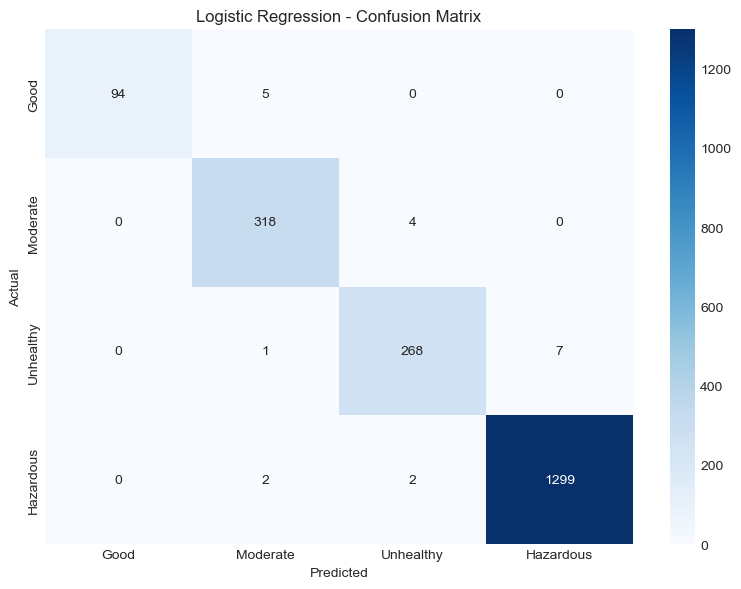

In [36]:
# Model 1: Logistic Regression
lr_model, lr_pred = train_evaluate_model('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42))

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, lr_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=label_map.values(), yticklabels=label_map.values())
plt.title('Logistic Regression - Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('graphs/7_models/logistic_regression_cm.png', dpi=150)
plt.show()


MODEL: Decision Tree
Accuracy: 0.9995 | Precision: 0.9995 | Recall: 0.9995 | F1: 0.9995

Confusion Matrix:
[[  99    0    0    0]
 [   0  322    0    0]
 [   0    0  276    0]
 [   0    1    0 1302]]


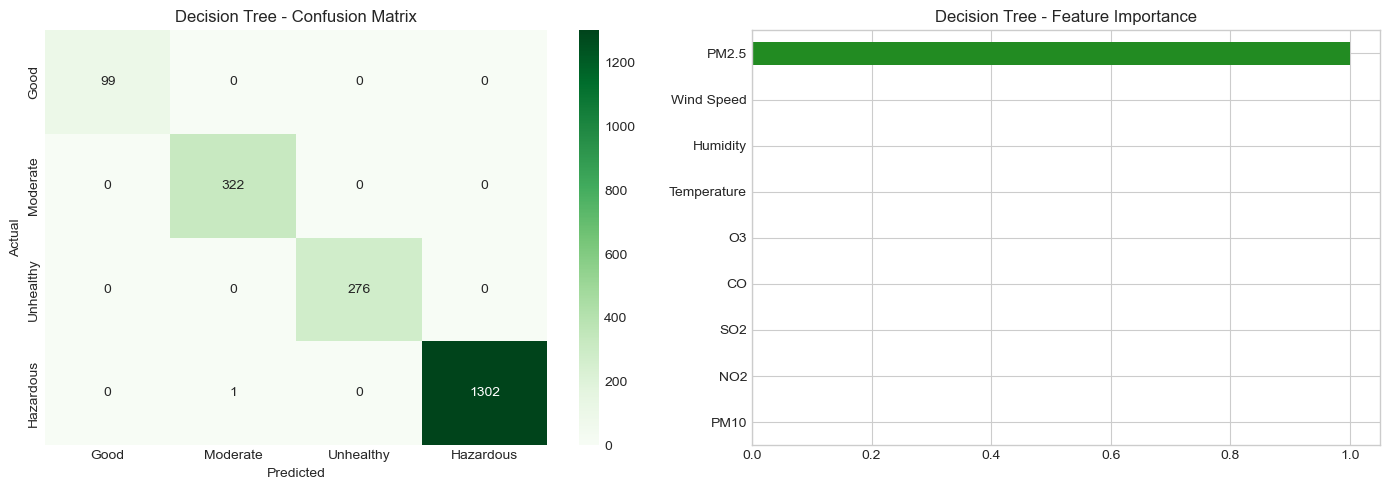

In [37]:
# Model 2: Decision Tree
dt_model, dt_pred = train_evaluate_model('Decision Tree', DecisionTreeClassifier(max_depth=10, random_state=42))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(confusion_matrix(y_test, dt_pred), annot=True, fmt='d', cmap='Greens', ax=axes[0],
            xticklabels=label_map.values(), yticklabels=label_map.values())
axes[0].set_title('Decision Tree - Confusion Matrix'); axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Actual')

dt_importance = pd.Series(dt_model.feature_importances_, index=features).sort_values()
dt_importance.plot(kind='barh', ax=axes[1], color='forestgreen')
axes[1].set_title('Decision Tree - Feature Importance')
plt.tight_layout()
plt.savefig('graphs/7_models/decision_tree.png', dpi=150)
plt.show()


MODEL: Random Forest
Accuracy: 0.9985 | Precision: 0.9985 | Recall: 0.9985 | F1: 0.9985

Confusion Matrix:
[[  99    0    0    0]
 [   0  322    0    0]
 [   0    0  276    0]
 [   0    3    0 1300]]


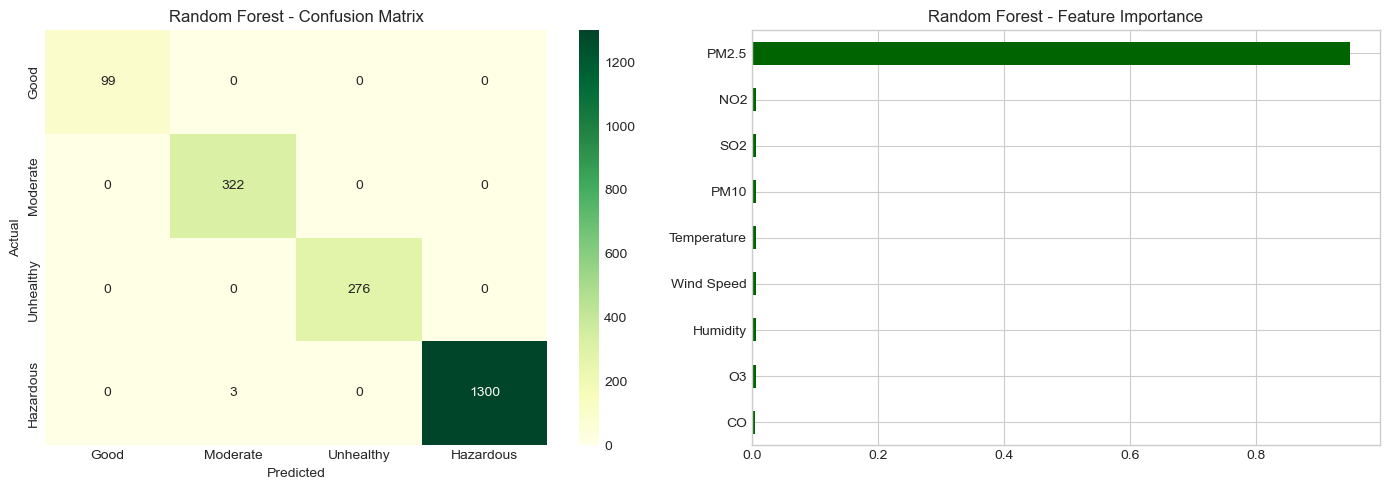

In [46]:
# Model 3: Random Forest
rf_model, rf_pred = train_evaluate_model('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt='d', cmap='YlGn', ax=axes[0],
            xticklabels=label_map.values(), yticklabels=label_map.values())
axes[0].set_title('Random Forest - Confusion Matrix'); axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Actual')

rf_importance = pd.Series(rf_model.feature_importances_, index=features).sort_values()
rf_importance.plot(kind='barh', ax=axes[1], color='darkgreen')
axes[1].set_title('Random Forest - Feature Importance')
plt.tight_layout()
plt.savefig('graphs/7_models/random_forest.png', dpi=150)
plt.show()


MODEL: SVM (RBF)
Accuracy: 0.9380 | Precision: 0.9431 | Recall: 0.9380 | F1: 0.9343

Confusion Matrix:
[[  42   57    0    0]
 [   1  300   21    0]
 [   0   14  250   12]
 [   0    2   17 1284]]


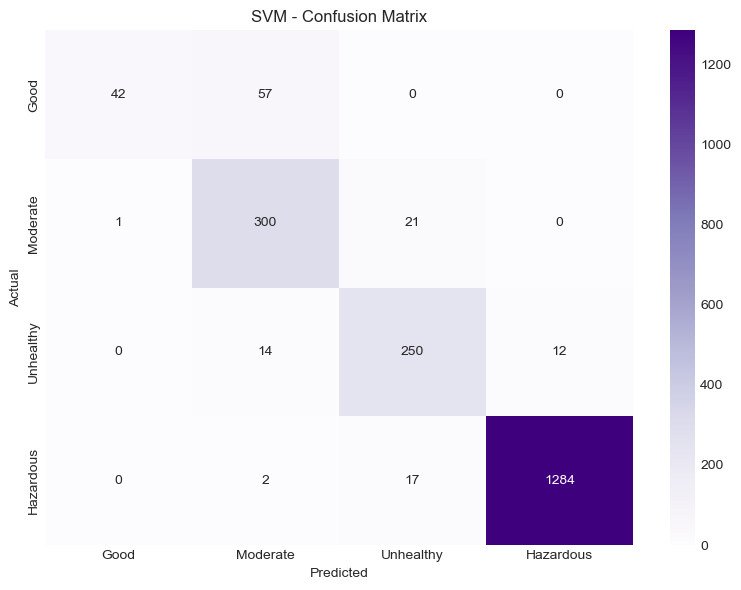

In [39]:
# Model 4: Support Vector Machine (SVM)
svm_model, svm_pred = train_evaluate_model('SVM (RBF)', SVC(kernel='rbf', random_state=42))

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, svm_pred), annot=True, fmt='d', cmap='Purples',
            xticklabels=label_map.values(), yticklabels=label_map.values())
plt.title('SVM - Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('graphs/7_models/svm_cm.png', dpi=150)
plt.show()

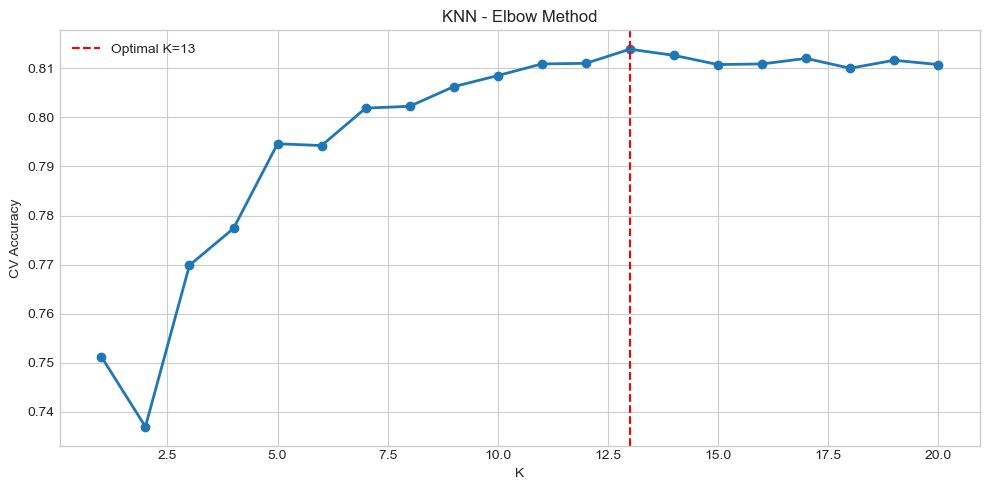


MODEL: KNN (K=13)
Accuracy: 0.7955 | Precision: 0.7642 | Recall: 0.7955 | F1: 0.7724

Confusion Matrix:
[[   4   88    7    0]
 [  11  226   73   12]
 [   0   80   91  105]
 [   0    7   26 1270]]


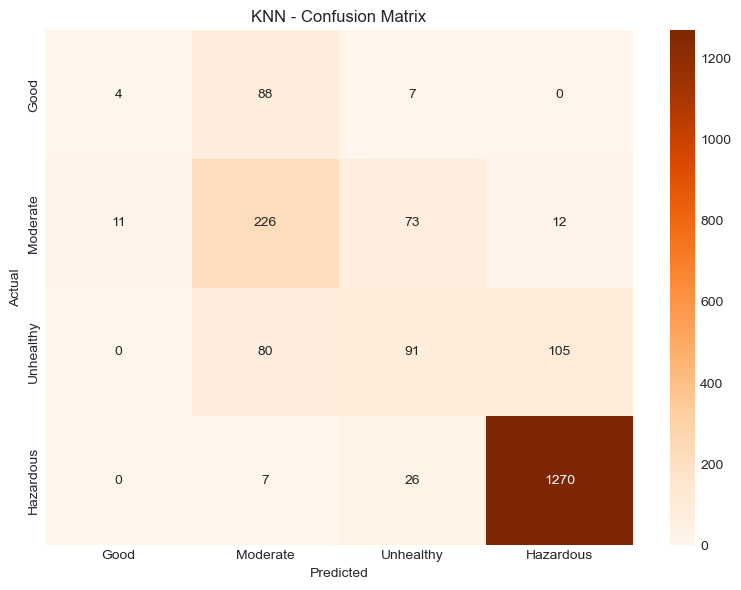

In [40]:
# Model 5: K-Nearest Neighbors (KNN) with Elbow Method
k_scores = []
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_score = cross_val_score(knn, X_train_scaled, y_train, cv=5).mean()
    k_scores.append(cv_score)

optimal_k = np.argmax(k_scores) + 1

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(1, 21), k_scores, marker='o', linewidth=2)
ax.axvline(optimal_k, color='red', linestyle='--', label=f'Optimal K={optimal_k}')
ax.set_xlabel('K'); ax.set_ylabel('CV Accuracy'); ax.set_title('KNN - Elbow Method')
ax.legend()
plt.tight_layout()
plt.savefig('graphs/7_models/knn_elbow.png', dpi=150)
plt.show()

knn_model, knn_pred = train_evaluate_model(f'KNN (K={optimal_k})', KNeighborsClassifier(n_neighbors=optimal_k))

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, knn_pred), annot=True, fmt='d', cmap='Oranges',
            xticklabels=label_map.values(), yticklabels=label_map.values())
plt.title('KNN - Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('graphs/7_models/knn_cm.png', dpi=150)
plt.show()

MODEL COMPARISON SUMMARY
                     Accuracy  Precision  Recall      F1  CV Score
Model                                                             
Logistic Regression    0.9895     0.9895  0.9895  0.9895    0.9898
Decision Tree          0.9995     0.9995  0.9995  0.9995    0.9999
Random Forest          0.9985     0.9985  0.9985  0.9985    0.9991
SVM (RBF)              0.9380     0.9431  0.9380  0.9343    0.9391
KNN (K=13)             0.7955     0.7642  0.7955  0.7724    0.8139
Logistic Regression    0.9895     0.9895  0.9895  0.9895    0.9898
Decision Tree          0.9995     0.9995  0.9995  0.9995    0.9999
Random Forest          0.9985     0.9985  0.9985  0.9985    0.9991
SVM (RBF)              0.9380     0.9431  0.9380  0.9343    0.9391
KNN (K=13)             0.7955     0.7642  0.7955  0.7724    0.8139

Best Model: Decision Tree (F1: 0.9995)


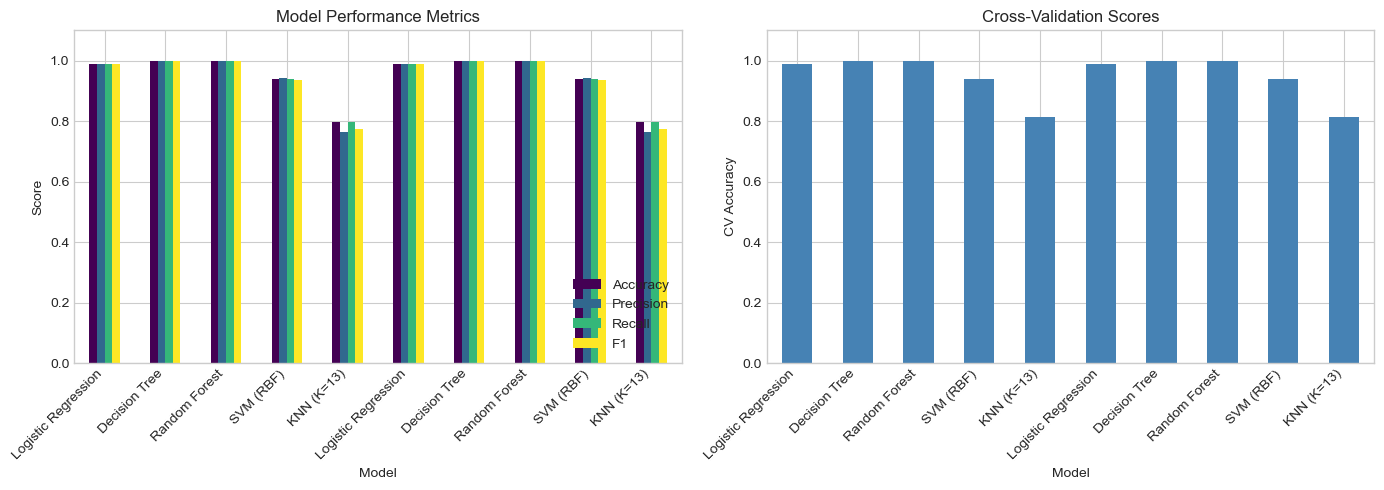

In [41]:
# Model Comparison
results_df = pd.DataFrame(results)
results_df = results_df.set_index('Model')
print("=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)
print(results_df.round(4).to_string())
print("\nBest Model:", results_df['F1'].idxmax(), f"(F1: {results_df['F1'].max():.4f})")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

results_df[['Accuracy', 'Precision', 'Recall', 'F1']].plot(kind='bar', ax=axes[0], colormap='viridis')
axes[0].set_title('Model Performance Metrics'); axes[0].set_ylabel('Score')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].legend(loc='lower right'); axes[0].set_ylim(0, 1.1)

results_df['CV Score'].plot(kind='bar', ax=axes[1], color='steelblue', capsize=5)
axes[1].set_title('Cross-Validation Scores'); axes[1].set_ylabel('CV Accuracy')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_ylim(0, 1.1)

plt.tight_layout()
plt.savefig('graphs/7_models/model_comparison.png', dpi=150)
plt.show()

In [ ]:
# Feature Importance (from Random Forest)
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(feature_importance['Feature'], feature_importance['Importance'], color='forestgreen')
ax.set_xlabel('Importance'); ax.set_title('Random Forest - Feature Importance')
for i, v in enumerate(feature_importance['Importance']):
    ax.text(v + 0.01, i, f'{v:.3f}', va='center')
plt.tight_layout()
plt.savefig('graphs/7_models/feature_importance.png', dpi=150)
plt.show()

print("\nTop 5 Most Important Features:")
print(feature_importance.tail().to_string(index=False))

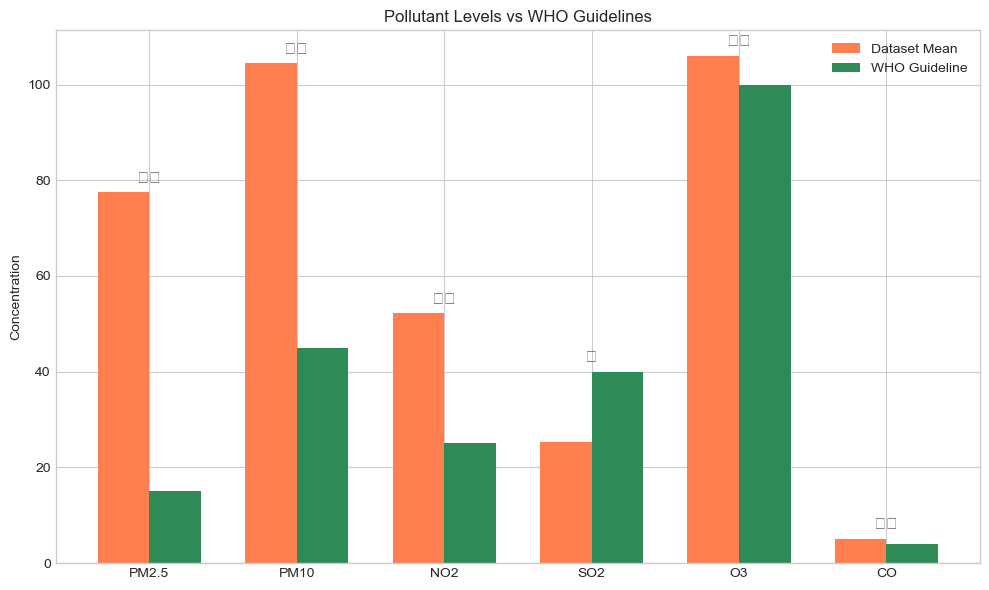


Health Risk Assessment:
  PM2.5: 77.45 (EXCEEDS WHO limit by 416.3%)
  PM10: 104.44 (EXCEEDS WHO limit by 132.1%)
  NO2: 52.20 (EXCEEDS WHO limit by 108.8%)
  SO2: 25.34 (WITHIN WHO limit by 36.6%)
  O3: 106.03 (EXCEEDS WHO limit by 6.0%)
  CO: 5.05 (EXCEEDS WHO limit by 26.2%)


In [33]:
# Health Impact Analysis - WHO Guidelines Comparison
who_guidelines = {'PM2.5': 15, 'PM10': 45, 'NO2': 25, 'SO2': 40, 'O3': 100, 'CO': 4}
actual_means = df[list(who_guidelines.keys())].mean()

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(who_guidelines))
width = 0.35
ax.bar(x - width/2, actual_means.values, width, label='Dataset Mean', color='coral')
ax.bar(x + width/2, list(who_guidelines.values()), width, label='WHO Guideline', color='seagreen')
ax.set_xticks(x); ax.set_xticklabels(who_guidelines.keys())
ax.set_ylabel('Concentration'); ax.set_title('Pollutant Levels vs WHO Guidelines')
ax.legend()
for i, (v1, v2) in enumerate(zip(actual_means.values, who_guidelines.values())):
    status = '⚠️' if v1 > v2 else '✓'
    ax.annotate(status, (i, max(v1, v2) + 2), ha='center', fontsize=12)
plt.tight_layout()
plt.savefig('graphs/5_comparative/who_comparison.png', dpi=150)
plt.show()

print("\nHealth Risk Assessment:")
for pollutant, who_val in who_guidelines.items():
    actual = actual_means[pollutant]
    pct = ((actual - who_val) / who_val) * 100
    status = "EXCEEDS" if actual > who_val else "WITHIN"
    print(f"  {pollutant}: {actual:.2f} ({status} WHO limit by {abs(pct):.1f}%)")

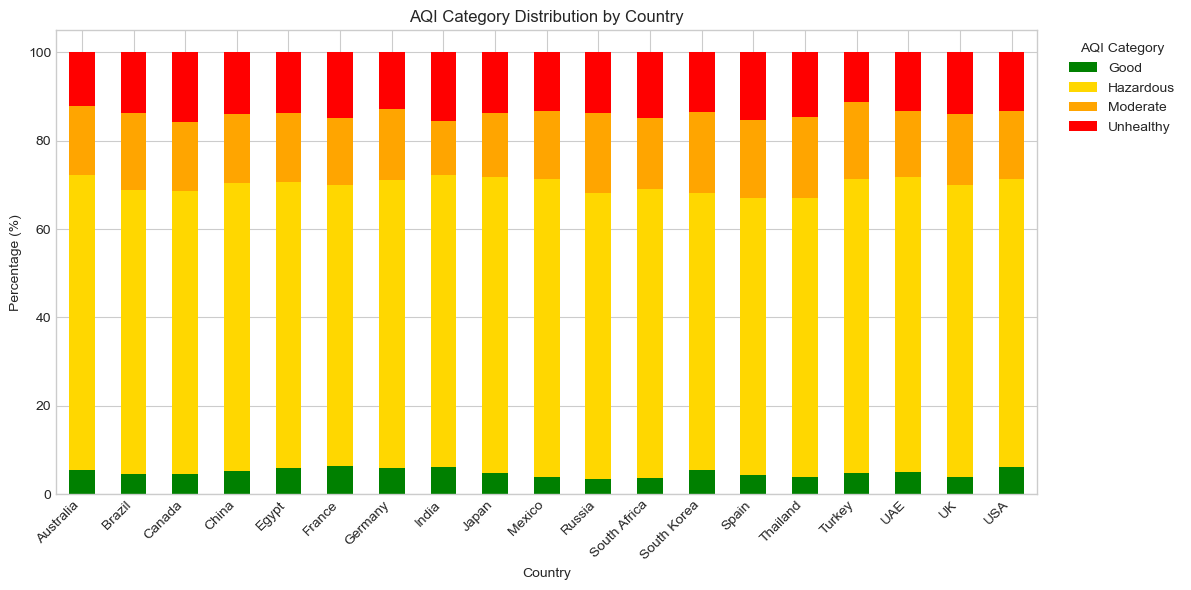

In [34]:
# AQI Category Distribution by Region
fig, ax = plt.subplots(figsize=(12, 6))
aqi_by_country = df.groupby(['Country', 'AQI_Category']).size().unstack(fill_value=0)
aqi_by_country = aqi_by_country.div(aqi_by_country.sum(axis=1), axis=0) * 100
aqi_by_country.plot(kind='bar', stacked=True, ax=ax, 
                    color=['green', 'gold', 'orange', 'red', 'purple', 'maroon'])
ax.set_ylabel('Percentage (%)'); ax.set_title('AQI Category Distribution by Country')
ax.legend(title='AQI Category', bbox_to_anchor=(1.02, 1))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.savefig('graphs/5_comparative/aqi_by_country.png', dpi=150)
plt.show()

In [ ]:
# Summary Statistics and Key Findings
print("=" * 80)
print("PROJECT SUMMARY: GLOBAL AIR QUALITY ANALYSIS")
print("=" * 80)
print(f"\nDataset: {len(df)} records from {df['Country'].nunique()} countries, {df['City'].nunique()} cities")
print(f"\nAQI Distribution:")
for cat in df['AQI_Category'].value_counts().index:
    pct = (df['AQI_Category'] == cat).sum() / len(df) * 100
    print(f"  {cat}: {pct:.1f}%")

print(f"\nBest Performing Model: {results_df['F1-Score'].idxmax()}")
print(f"  - F1-Score: {results_df['F1-Score'].max():.4f}")
print(f"  - Accuracy: {results_df.loc[results_df['F1-Score'].idxmax(), 'Accuracy']:.4f}")

print(f"\nTop 3 Important Features:")
for _, row in feature_importance.tail(3).iterrows():
    print(f"  - {row['Feature']}: {row['Importance']:.4f}")

print("\nKey Recommendations:")
print("  1. Focus monitoring on PM2.5 and PM10 as primary health risk indicators")
print("  2. Implement targeted interventions in regions with 'Unhealthy' or worse AQI")
print("  3. Use ML models for real-time AQI prediction and early warning systems")
print("  4. Weather conditions (temp, humidity) significantly influence pollutant levels")
print("=" * 80)

In [ ]:
# Save Final Results to CSV
results_df.to_csv('model_results.csv')
feature_importance.to_csv('feature_importance.csv', index=False)
print("Results saved to CSV files!")
print(f"\nAll graphs saved to organized folders:")
for folder in sorted(os.listdir('graphs')):
    files = os.listdir(f'graphs/{folder}')
    print(f"  📁 graphs/{folder}/ ({len(files)} files)")
    for f in files:
        print(f"      └── {f}")